In [462]:
#numpy
import numpy as np
from numpy.random import multivariate_normal #For later example

#advectionGP
from advectionGP.models.mesh_1d_ode_model import AdjointSecondOrderODEModel as Model #Model module builds basic parts of the ODE problem, combines other classes into full model

'''To use other models in the class, such as the Advection Diffusion Reaction model, 
replace "AdjointSecondOrderODEModel" in the line above with "AdjointAdvectionDiffusionReaction" model
and adjust parameters as appropriate'''

from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
#from advectionGP.test import TestKernels #Unit test model


#Plotting tools
import matplotlib.pyplot as plt

In [477]:
fontS=20

In [478]:
avg=0.01 # time that an observation is taken for
tlocL = np.linspace(1,9,20) # observation start times
X= np.zeros((len(tlocL),2)) # initiate X
# Build sensor locations
X[:,0] = tlocL #lower time#
X[:,1] = X[:,0]+avg # upper time

In [479]:
sensors = FixedSensorModel(X,0) # establish sensor model arguments are sensor locations and spatial averaging (not applicable in 1D case so set to 0)

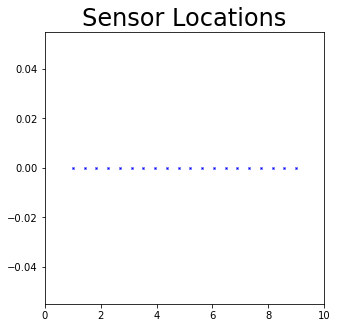

In [480]:
plt.rcParams["figure.figsize"] = (5,5)

plt.xlim(0,10)
plt.title("Sensor Locations",fontsize=24)
plt.plot((X[:,1]-avg/2),np.zeros(len(X)),'xk',markersize=2,color='b');

In [481]:
np.random.seed(123)
k_0 = -0.01 #Diffusion coefficient
u=0.1
eta=0.1
noiseSD = 0.05 #Observation noise
N_feat=2000 # number of features used to approximate ground truth GP
boundary = ([0],[10])# edges of the grid - in units of time
kForward = EQ(0.3, 1.0) # generate EQ kernel arguments are lengthscale and variance
res = [500] # grid size for time

In [482]:
m = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kForward,sensormodel=sensors,k_0=k_0,u=u,eta=eta) #initiate PDE model to build concentration

dt, Nt = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute source
sourceGT=m.computeSourceFromPhi(z)# Compute ground truth source by approximating GP
#sourceGT = np.ones(m.resolution)  # Example constant source
concTrain=m.computeResponse(sourceGT) # Compute concentration - runs ODE forward model
yTrain= m.computeObservations(addNoise='TRUE') # Compute observations with noise uses m.sensormodel for observation locations

In [483]:
#%%timeit
np.random.seed(124)
N_feat =100 #Number of features used to infer the source
kInverse = EQ(0.3, 1.0) # Initiate kernel for inverse problem
#x=[1,1,-1]
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kInverse,sensormodel=sensors,k_0=k_0,u=u,eta=eta) #Initiate new model for inference
mInfer.computeModelRegressors() # Compute regressor matrix 
meanZ, covZ = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance using regressor matrix
sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution
concInfer=mInfer.computeResponse(sourceInfer) # Generates estimated concentration from inferred source



Computing SS...
Inverting SS...
Computing meanZ
Done


In [484]:
meanSource, varSource  = mInfer.computeSourceDistribution(meanZ,covZ)

In [485]:
varSource.shape

(500,)

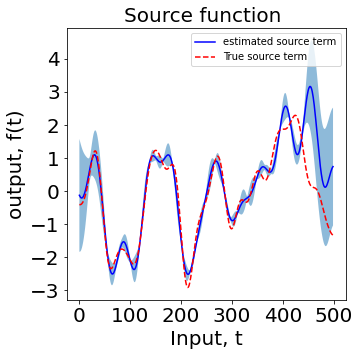

In [486]:
xtest=np.arange(Nt)

#plt.figure(figsize=(15, 10))

plt.plot(xtest,sourceInfer,'b-')
plt.plot(xtest,sourceGT,'r--')

#plt.plot(xtest,source_samples.T,'g-',alpha=0.3)
#plt.fill_between(xtest,s_z_l,s_z_upper,alpha=0.5)
plt.fill_between(xtest,sourceInfer-1.96*np.sqrt(varSource),sourceInfer+1.96*np.sqrt(varSource),alpha=0.5)
plt.legend(labels=["estimated source term","True source term"])
plt.title("Source function ",fontsize=fontS)
plt.xlabel("Input, t",fontsize=fontS)
plt.ylabel("output, f(t)",fontsize=fontS)
plt.xticks(fontsize=fontS)
plt.yticks(fontsize=fontS)
#plt.ylim([-5,5])
plt.savefig('NumberFeature%d.pdf' % N_feat)
plt.show()

In [487]:
concLower=mInfer.computeResponse(sourceInfer-1.96*np.sqrt(varSource))
concUpper=mInfer.computeResponse(sourceInfer+1.96*np.sqrt(varSource))

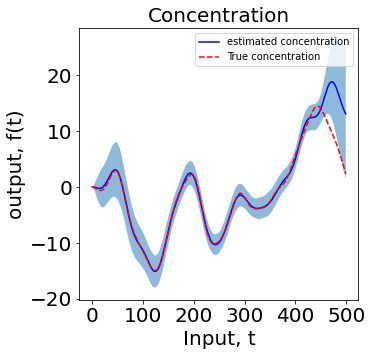

In [488]:
plt.plot(xtest,concInfer,'b-')
plt.plot(xtest,concTrain,'r--')

#plt.plot(xtest,source_samples.T,'g-',alpha=0.3)
#plt.fill_between(xtest,s_z_l,s_z_upper,alpha=0.5)
plt.fill_between(xtest,concLower,concUpper,alpha=0.5)
plt.legend(labels=["estimated concentration","True concentration"])
plt.title("Concentration",fontsize=fontS)
plt.xlabel("Input, t",fontsize=fontS)
plt.ylabel("output, f(t)",fontsize=fontS)
plt.xticks(fontsize=fontS)
plt.yticks(fontsize=fontS)
#plt.ylim([-5,5])
plt.show()

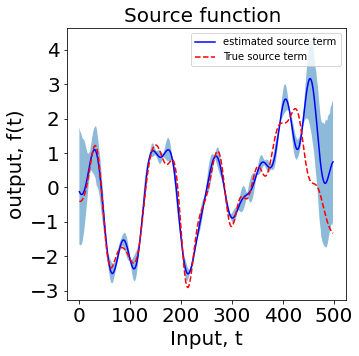

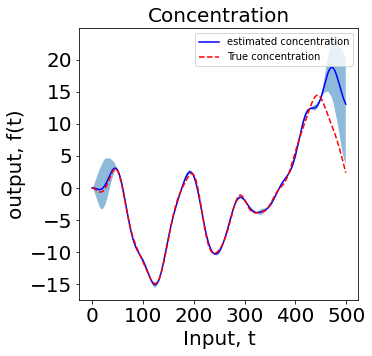

In [489]:
source_samples = []
conc_samples=[]    

for z_samp in np.random.multivariate_normal(meanZ, covZ,200):
    source_samples.append(mInfer.computeSourceFromPhi(z_samp))
    conc_samples.append(mInfer.computeResponse(mInfer.computeSourceFromPhi(z_samp)))
source_samples=np.array(source_samples)
conc_samples=np.array(conc_samples)

source_lower_ci = np.percentile(source_samples,2.5,0)
source_upper_ci = np.percentile(source_samples,97.5,0)
source_mean = np.percentile(source_samples,50,0)

conc_lower_ci = np.percentile(conc_samples,2.5,0)
conc_upper_ci = np.percentile(conc_samples,97.5,0)
conc_mean = np.percentile(conc_samples,50,0)

xtest=np.arange(Nt)

#plt.figure(figsize=(15, 10))

plt.plot(xtest,sourceInfer,'b-')
plt.plot(xtest,sourceGT,'r--')

#plt.plot(xtest,source_samples.T,'g-',alpha=0.3)
#plt.fill_between(xtest,s_z_l,s_z_upper,alpha=0.5)
plt.fill_between(xtest,source_lower_ci,source_upper_ci,alpha=0.5)
plt.legend(labels=["estimated source term","True source term"])
plt.title("Source function ",fontsize=fontS)
plt.xlabel("Input, t",fontsize=fontS)
plt.ylabel("output, f(t)",fontsize=fontS)
#plt.ylim([-5,5])
plt.savefig('NumberFeature%d.pdf' % N_feat)
plt.xticks(fontsize=fontS)
plt.yticks(fontsize=fontS)
plt.show()

#plt.figure(figsize=(15, 10))

plt.plot(xtest,concInfer,'b-')
plt.plot(xtest,concTrain,'r--')

#plt.plot(xtest,source_samples.T,'g-',alpha=0.3)
#plt.fill_between(xtest,s_z_l,s_z_upper,alpha=0.5)
plt.fill_between(xtest,conc_lower_ci,conc_upper_ci,alpha=0.5)
plt.legend(labels=["estimated concentration","True concentration"])
plt.title("Concentration",fontsize=fontS)
plt.xlabel("Input, t",fontsize=fontS)
plt.ylabel("output, f(t)",fontsize=fontS)
plt.xticks(fontsize=fontS)
plt.yticks(fontsize=fontS)
#plt.ylim([-5,5])
plt.savefig('NumberFeature%d.pdf' % N_feat)
plt.show()

### ADR 1D

In [1]:
#numpy
import numpy as np
from numpy.random import multivariate_normal #For later example

#advectionGP

from advectionGP.models.mesh_adr1d_model import AdjointAdvectionDiffusionReaction1DModel as Model

from advectionGP.wind import WindFixU#Wind model


from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.kernels import GaussianBases #Generates exponentiated quadratic kernel approximation
#from advectionGP.test import TestKernels #Unit test model


#Plotting tools
import matplotlib.pyplot as plt

In [18]:
# generate sensor locations for training data with shape [total observations, 4], where each row has elements 
#[lower time location, upper time location, x location, y location]

tlocL = np.linspace(1,9,10) # lower time
xloc=np.linspace(1,9,10) # x locations
sensN = len(xloc) # total number of sensors 
obsN = len(tlocL) # total time points at which an observation is taken
X= np.zeros((obsN*sensN,3)) # obsN*sensN is total observations over all sensors and all times
# Build sensor locations
X[:,0] = np.asarray(np.meshgrid(tlocL,xloc)).reshape(2,sensN*obsN)[0] #lower time
X[:,2] = np.asarray(np.meshgrid(tlocL,xloc)).reshape(2,sensN*obsN)[1] # x location
X[:,1] = X[:,0]+0.1 # upper time

sensors = FixedSensorModel(X,0.001) # establish sensor model arguments are sensor locations and spatial averaging

In [114]:
np.random.seed(1)
k_0 = 0.0005 #Diffusion
R=0.0
noiseSD = 0.5 #Observation noise
N_feat=2000 # number of features used to approximate ground truth GP
boundary = ([0,0],[10,10])# corners of the grid - in units of space
k = EQ(1, 2.0) # generate EQ kernel arguments are lengthscale and variance
res = [1000,100] # grid size for time, x and y

gg = []
for d in range(2):
    gg.append(np.linspace(boundary[0][d],boundary[1][d],res[d]))
        
coords=np.asarray(np.meshgrid(gg[0],gg[1],indexing='ij'))

u1 = 1*np.sin(2*coords[0])
u2 = 0*np.ones(res)
u=np.array([u1,u2])
windmodel=WindFixU(u) # establish fixed wind model
m = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0,R=R) #initiate PDE model to build concentration

delta,Ns = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute source

sourceGT=(m.computeSourceFromPhi(z))# Compute source

#sourceGT[500:999:,]=0

#sourceGT = np.zeros(m.resolution)
#x = np.linspace(0,10,50)

#sourceGT[:,0:50]=np.exp(-(1/1)*(x-5)**2)

In [115]:
sourceGT[50:99,:].shape

(49, 100)

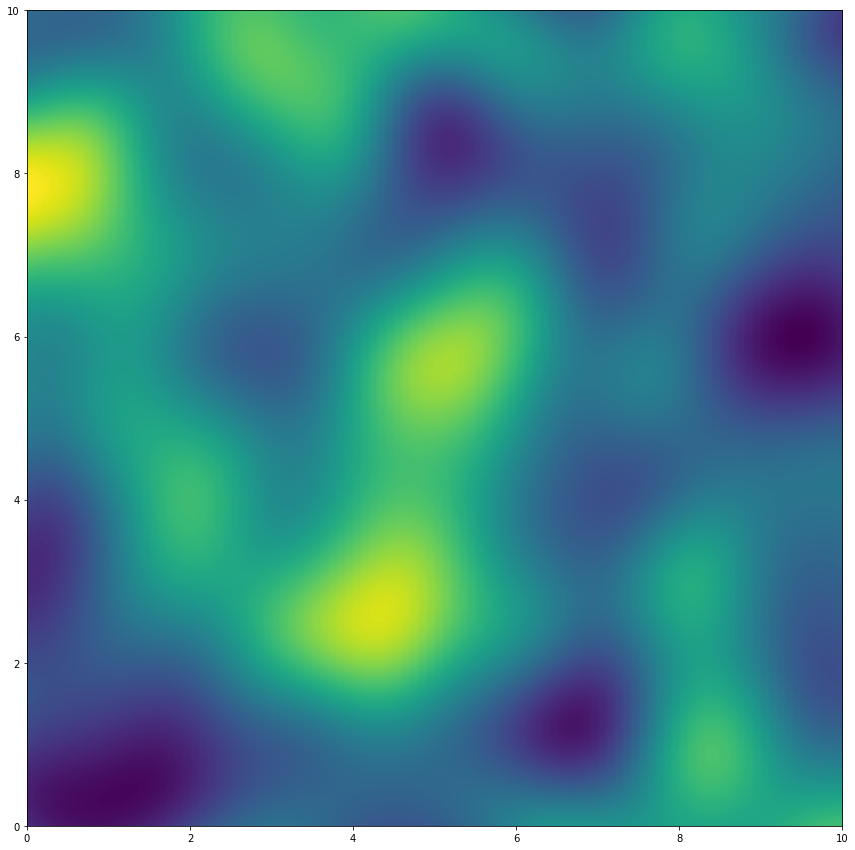

In [116]:
plt.imshow(sourceGT,extent=[0,10,0,10],origin='lower')

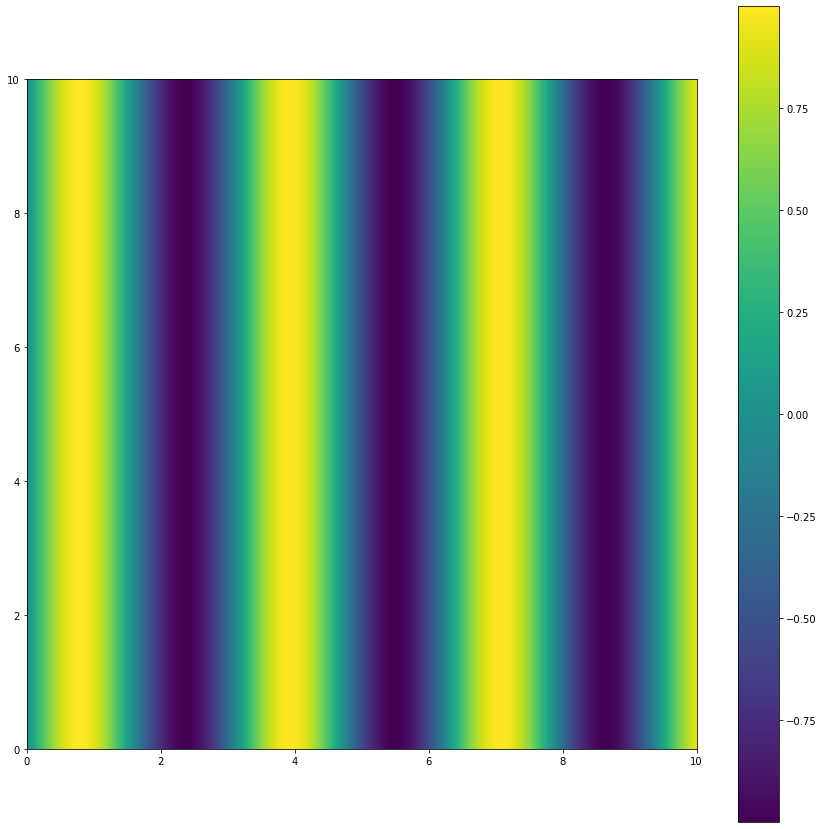

In [117]:
plt.imshow(u1.T,extent=[0,10,0,10],origin='lower')
plt.colorbar()

In [118]:
m.sensormodel=sensors
concTrain=m.computeResponse(sourceGT) # Compute concentration - runs advection diffusion forward model
yTrain= m.computeObservations(addNoise=True) # Compute observations with noise uses m.sensormodel for observation locations

In [119]:
np.random.seed(1)
N_feat =1000 #Number of features used to infer the source
#k1 = EQ(0.5, 1.0) 
k2 = EQ(1, 2.0) 

mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k2,sensormodel=sensors,windmodel=windmodel,k_0=k_0,R=R) #Initiate new model for inference
regressInfer = mInfer.computeModelRegressors() # Compute regressor matrix
meanZ, covZ = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance
sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using inferred distributio
concInfer = mInfer.computeResponse(sourceInfer)

yOut = mInfer.computeObservations()



Computing SS...
Inverting SS...
Computing meanZ
Done


In [120]:
fontS = 20

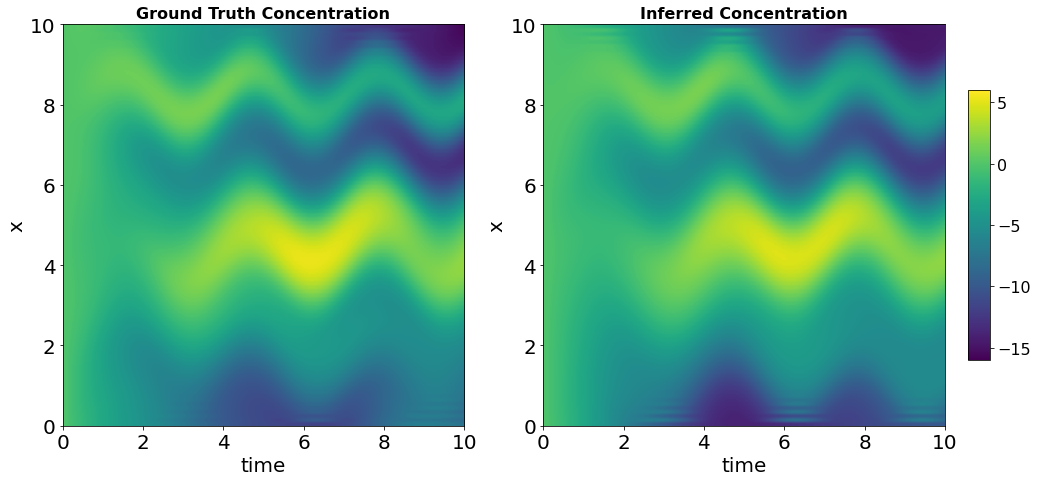

In [121]:
a=np.floor(np.min((np.min(concInfer),np.min(concTrain))))
b=np.ceil(np.max((np.max(concTrain),np.max(concInfer))))
plt.rcParams["figure.figsize"] = (15,15)
fig = plt.figure()

ploti = 0
for title, data in zip(['Ground Truth Concentration','Inferred Concentration'],[concTrain.T, concInfer.T]):
    ploti+=1
    plt.subplot(1,2,ploti)
    im1=plt.imshow(data, extent=[0,10,0,10],origin='lower') #fix t...
    #time = t*dt
    plt.xlabel("time",fontsize=fontS)
    plt.ylabel("x",fontsize=fontS)
    plt.xticks(fontsize=fontS)
    plt.yticks(fontsize=fontS)
    plt.clim(a,b)


    tick_font_size = 16
    plt.title(title, fontsize=16, fontweight='bold')
    #if ploti % 3 == 3:
    #    plt.colorbar(im1,fraction=0.046, pad=0.04)

fig.tight_layout(rect=[0.1, 0.2, 1, 1])

cbar_ax = fig.add_axes([1, 0.475, 0.02, 0.25])
cbar=fig.colorbar(im1, cax=cbar_ax,orientation='vertical')
#cbar = plt.colorbar(im3,fraction=0.046)
tick_font_size = 16
cbar.ax.tick_params(labelsize = tick_font_size)
plt.show()

In [122]:
mInfer.kernel.l2

array([1, 1])

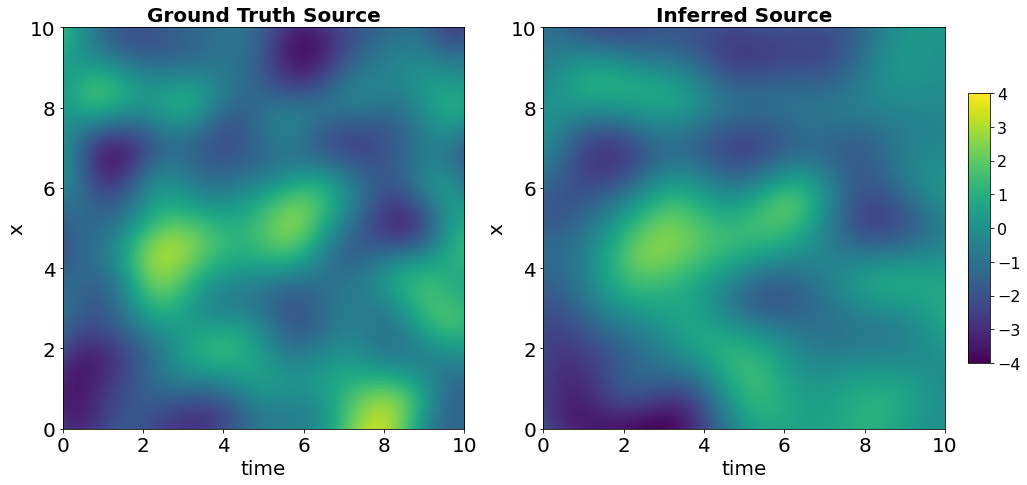

In [123]:
a=np.floor(np.min((np.min(sourceInfer),np.min(sourceGT))))
b=np.ceil(np.max((np.max(sourceInfer),np.max(sourceGT))))
plt.rcParams["figure.figsize"] = (15,15)
fig = plt.figure()

ploti = 0
for title, data in zip(['Ground Truth Source','Inferred Source'],[sourceGT.T, sourceInfer.T]):
    ploti+=1
    plt.subplot(1,2,ploti)
    im1=plt.imshow(data, extent=[0,10,0,10],origin='lower') #fix t...
    #time = t*dt
    plt.xlabel("time",fontsize=fontS)
    plt.ylabel("x",fontsize=fontS)
    plt.xticks(fontsize=fontS)
    plt.yticks(fontsize=fontS)
    plt.clim(a,b)


    tick_font_size = 16
    plt.title(title, fontsize=fontS, fontweight='bold')
    #if ploti % 3 == 3:
    #    plt.colorbar(im1,fraction=0.046, pad=0.04)

fig.tight_layout(rect=[0.1, 0.2, 1, 1])

cbar_ax = fig.add_axes([1, 0.475, 0.02, 0.25])
cbar=fig.colorbar(im1, cax=cbar_ax,orientation='vertical')
#cbar = plt.colorbar(im3,fraction=0.046)
tick_font_size = 16
cbar.ax.tick_params(labelsize = tick_font_size)
plt.show()

In [670]:
meanSource, varSource  = mInfer.computeSourceDistribution(meanZ,covZ)

KeyboardInterrupt: 

In [ ]:
plt.imshow(varSource, extent=[0,10,0,10],origin='lower')
plt.colorbar()

## ADR 2D

In [125]:
#numpy
import numpy as np
from numpy.random import multivariate_normal #For later example

#advectionGP

from advectionGP.models.mesh_adr2d_model import AdjointAdvectionDiffusionReaction2DModel as PDEModel

from advectionGP.wind import WindFixU#Wind model


from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
#from advectionGP.test import TestKernels #Unit test model


#Plotting tools
import matplotlib.pyplot as plt

In [126]:
# generate sensor locations for training data with shape [total observations, 4], where each row has elements 
#[lower time location, upper time location, x location, y location]

tlocL = np.linspace(1,9,10) # lower time
xloc=np.linspace(1,9,5) # x locations
yloc=np.linspace(1,9,5) # y locations
sensN = len(xloc)*len(yloc) # total number of sensors 
obsN = len(tlocL) # total time points at which an observation is taken
X= np.zeros((obsN*sensN,4)) # obsN*sensN is total observations over all sensors and all times
# Build sensor locations
X[:,0] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[0] #lower time
X[:,2] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[1] # x location
X[:,3] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[2] # ylocation
X[:,1] = X[:,0]+0.1 # upper time

sensors = FixedSensorModel(X,0.1) # establish sensor model arguments are sensor locations and spatial averaging

In [141]:
k_0 = 0.1 #Diffusion
R=1
noiseSD = 0.05 #Observation noise
N_feat=2000 # number of features used to approximate ground truth GP
boundary = ([0,0,0],[10,10,10])# corners of the grid - in units of space
k = EQ(2, 2.0) # generate EQ kernel arguments are lengthscale and variance
res = [200,50,50] # grid size for time, x and y

gg = []
for d in range(3):
    gg.append(np.linspace(boundary[0][d],boundary[1][d],res[d]))
        
coords=np.asarray(np.meshgrid(gg[0],gg[1],gg[2],indexing='ij'))


u1 = 0.5*np.sin(-5*coords[0])
u2 = 0*np.ones(res)
u=np.array([u1,u2])
windmodel=WindFixU(u) # establish fixed wind model
m = PDEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0,R=R) #initiate PDE model to build concentration

delta,Ns = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute source

sourceGT=(m.computeSourceFromPhi(z))# Compute source

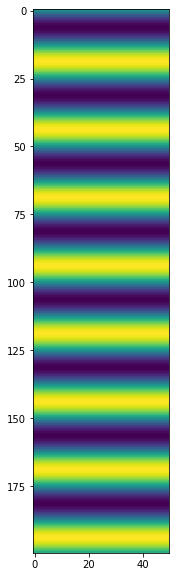

In [142]:
plt.imshow(u1[:,20,:])

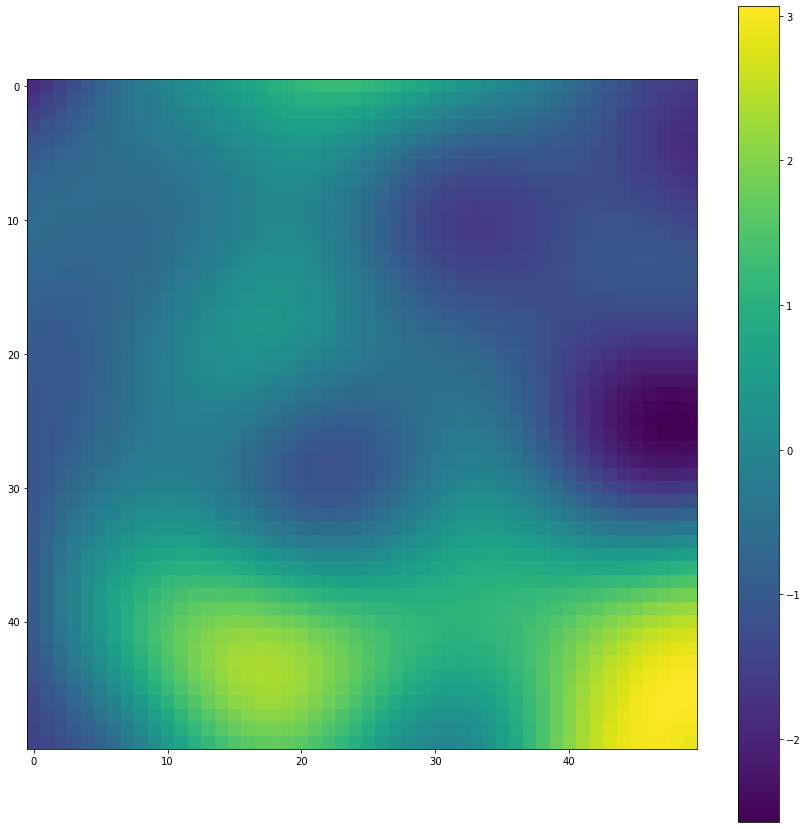

In [131]:
plt.imshow(sourceGT[0])
plt.colorbar()

In [132]:
m.sensormodel=sensors
concTrain=m.computeResponse(sourceGT) # Compute concentration - runs advection diffusion forward model
#concTrain[concTrain<0]=0
#m.concentration=concTrain
yTrain= m.computeObservations(addNoise=True) # Compute observations with noise uses m.sensormodel for observation locations

In [133]:
N_feat =200 #Number of features used to infer the source
k1 = EQ(2, 2.0) 
k2 = EQ(0.3, 2.0) 

mInfer = PDEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k1,sensormodel=sensors,windmodel=windmodel,k_0=k_0,R=R) #Initiate new model for inference
regressInfer = mInfer.computeModelRegressors() # Compute regressor matrix
meanZ, covZ = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance
sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using inferred distributio

concInfer = mInfer.computeResponse(sourceInfer)

yOut = mInfer.computeObservations()



Computing SS...
Inverting SS...
Computing meanZ
Done


In [134]:
meanSource, varSource  = mInfer.computeSourceDistribution(meanZ,covZ)

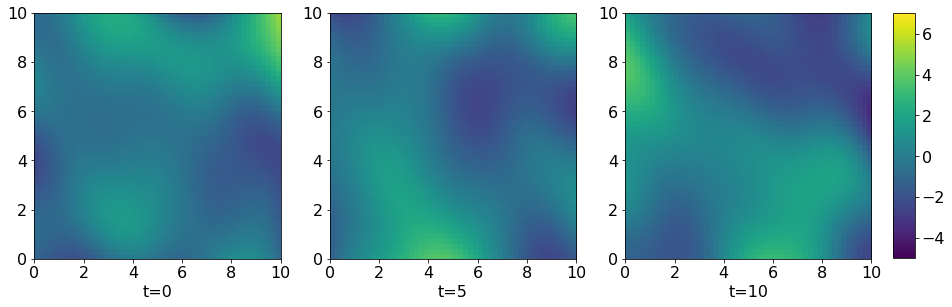

In [135]:
source=sourceInfer
a=np.floor(np.min(source))
b=np.ceil(np.max(source))
plt.rcParams["figure.figsize"] = (15,10)
fig = plt.figure()

plt.subplot(131)
im1=plt.imshow(source[0], extent=[0,10,0,10],origin='lower')
plt.xlabel("t=0",fontsize=16)
#plt.ylabel("y",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.clim(a,b)
#cbar = plt.colorbar(im1,fraction=0.046, pad=0.04)
tick_font_size = 16
#cbar.ax.tick_params(labelsize = tick_font_size)

plt.subplot(132)
im2=plt.imshow(source[99], extent=[0,10,0,10],origin='lower')
plt.xlabel("t=5",fontsize=16)
#plt.ylabel("y",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.clim(a,b)
#cbar = plt.colorbar(im2,fraction=0.046, pad=0.04)
tick_font_size = 16
#cbar.ax.tick_params(labelsize = tick_font_size)

plt.subplot(133)
im3=plt.imshow(source[199], extent=[0,10,0,10],origin='lower')
plt.xlabel("t=10",fontsize=16)
#plt.ylabel("y",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.clim(a,b)

fig.subplots_adjust(bottom=0.25)
cbar_ax = fig.add_axes([0.92, 0.395, 0.02, 0.34])
cbar=fig.colorbar(im1, cax=cbar_ax,orientation='vertical')
#cbar = plt.colorbar(im3,fraction=0.046)
tick_font_size = 16
cbar.ax.tick_params(labelsize = tick_font_size)
plt.show()

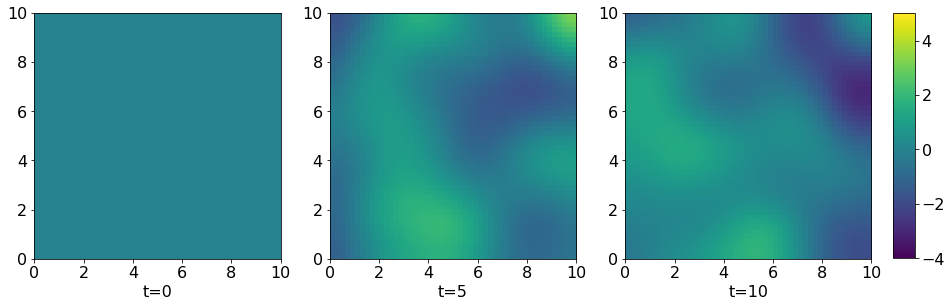

In [136]:
a=np.floor(np.min(concInfer))
b=np.ceil(np.max(concInfer))
plt.rcParams["figure.figsize"] = (15,10)
fig = plt.figure()

plt.subplot(131)
im1=plt.imshow(concTrain[0], extent=[0,10,0,10],origin='lower')
plt.xlabel("t=0",fontsize=16)
#plt.ylabel("y",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.clim(a,b)
#cbar = plt.colorbar(im1,fraction=0.046, pad=0.04)
tick_font_size = 16
#cbar.ax.tick_params(labelsize = tick_font_size)

plt.subplot(132)
im2=plt.imshow(concTrain[99], extent=[0,10,0,10],origin='lower')
plt.xlabel("t=5",fontsize=16)
#plt.ylabel("y",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.clim(a,b)
#cbar = plt.colorbar(im2,fraction=0.046, pad=0.04)
tick_font_size = 16
#cbar.ax.tick_params(labelsize = tick_font_size)

plt.subplot(133)
im3=plt.imshow(concTrain[199], extent=[0,10,0,10],origin='lower')
plt.xlabel("t=10",fontsize=16)
#plt.ylabel("y",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.clim(a,b)

fig.subplots_adjust(bottom=0.25)
cbar_ax = fig.add_axes([0.92, 0.395, 0.02, 0.34])
cbar=fig.colorbar(im1, cax=cbar_ax,orientation='vertical')
#cbar = plt.colorbar(im3,fraction=0.046)
tick_font_size = 16
cbar.ax.tick_params(labelsize = tick_font_size)
plt.show()

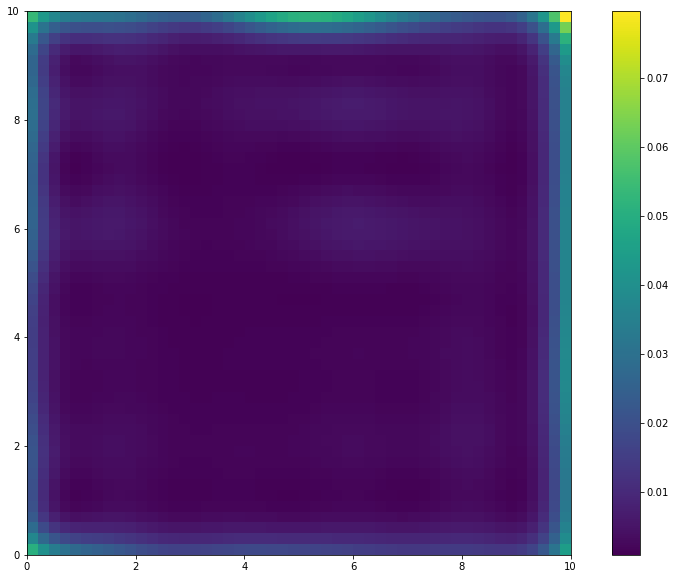

In [544]:
plt.imshow(varSource[99], extent=[0,10,0,10],origin='lower')
plt.colorbar()